In [1]:
import gym
import sys
import linearstochlearnerdynamics
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def getOptWeights(m, rewards, pos_weights, alpha):
    policyvals = dict()
    
    for i, j, k in pos_weights:
        
        a = np.array([
            [alpha*m[0][i][0]-1, alpha*m[0][i][1], alpha*m[0][i][2]],
            [alpha*m[1][j][0], alpha*m[1][j][1]-1, alpha*m[1][j][2]],
            [alpha*m[2][k][0], alpha*m[2][k][1], alpha*m[2][k][2]-1]
        ])
        
        b = np.array([
            -(m[0][i][0]*rewards[0][0]+m[0][i][1]*rewards[0][1]+m[0][i][2]*rewards[0][2]),
            -(m[1][j][0]*rewards[1][0]+m[1][j][1]*rewards[1][1]+m[1][j][2]*rewards[1][2]),
            -(m[2][k][0]*rewards[2][0]+m[2][k][1]*rewards[2][1]+m[2][k][2]*rewards[2][2])
        ])
        
        v = np.linalg.solve(a, b)
        policyvals[(i,j,k)] = v
            
    return policyvals

def getStatProb(policy, trans_matrix):
    a = np.array([
        [trans_matrix[0][policy[0]][0]-1, trans_matrix[1][policy[1]][0], trans_matrix[2][policy[2]][0]],
        [trans_matrix[0][policy[0]][1], trans_matrix[1][policy[1]][1]-1, trans_matrix[2][policy[2]][1]],
        [1,1,1]
    ])
    b = np.array([0, 0, 1])
    return np.linalg.solve(a, b)

[2017-12-04 10:29:34,031] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:29:34,098] Making new env: ToyProblem3-Random-v0


[ 0.55695054  0.31944065]
1 1 0


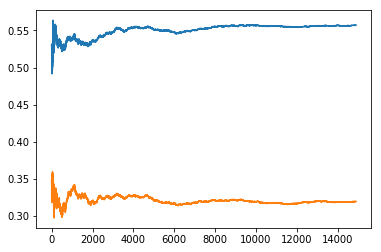

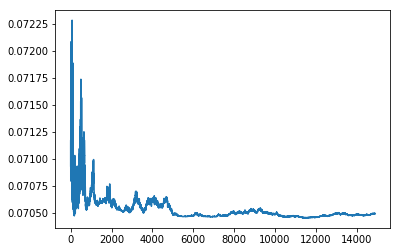

[2017-12-04 10:29:43,919] Making new env: ToyProblem3-Random-v0


[ 0.89612951  0.40434781]
1 1 0


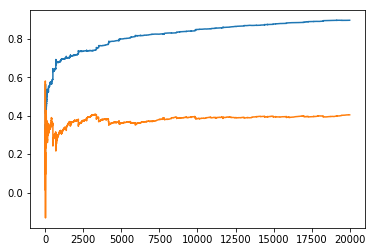

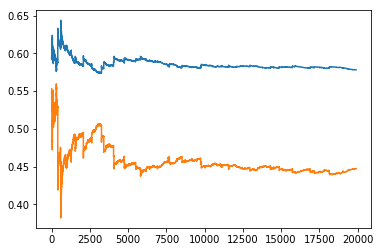

STD = TD


In [3]:
# Set random feature vector with each uniform [0, 2]
feat = np.random.rand(3,2)*2

# Set random discount alpha in Unif[0,1]
alpha_rand = np.random.rand(1)[0]

# Set up dummy environment 
dummy = linearstochlearnerdynamics.linearStochLearner(feat, 'TD', 'ToyProblem3-Random-v0', alpha = alpha_rand)

## Get trans_matrix and reward function from environment
trans_matrix = dummy.env.unwrapped.trans_matrix
rewards = dummy.env.unwrapped.rewards


## Generate random policy to evaluate
w = np.random.rand(2)
m = trans_matrix
r = rewards
vA, vB, vC = sum(feat[0] * w), sum(feat[1] * w), sum(feat[2] * w)

dummy.w = w
policy = [dummy.getAction(0), dummy.getAction(1), dummy.getAction(2)]
    
opt_weights = w
statprob = getStatProb(policy, trans_matrix)

all_weights = []
for i in range(2):
    for j in range(2):
        for k in range(2):
            all_weights.append((i,j,k))

policyvals = getOptWeights(trans_matrix, rewards, all_weights, alpha_rand)


########## TD
## Set up environment for TD
td=linearstochlearnerdynamics.linearStochLearner(feat, 'TD', 'ToyProblem3-Random-v0', alpha = alpha_rand)

## Copy trans_matrix and reward function to environment
td.env.unwrapped.trans_matrix = trans_matrix
td.env.unwrapped.rewards = rewards

## Set weight with best policy
td.w = opt_weights.copy()

## Solve TD and print new weights
td.policyIterate(num_iter=1, num_ep=150)
print(td.w)

## Get action at each state
print(td.getAction(0), td.getAction(1), td.getAction(2))
plt.plot(td.weights[100:])
plt.show()

## Plot Loss
tdloss = np.square(td.weights@np.transpose(feat)-policyvals[tuple(policy)])@statprob
plt.plot(tdloss[100:])
plt.show()

########## STD
## Set up environment for STD
std=linearstochlearnerdynamics.linearStochLearner(feat, 'STD-01', 'ToyProblem3-Random-v0', alpha = alpha_rand)

## Copy trans_matrix and reward function to environment
std.env.unwrapped.trans_matrix = trans_matrix
std.env.unwrapped.rewards = rewards

## Set weight with best policy
std.w = opt_weights

## Solve STD and print new weights
std.policyIterate(num_iter=1, num_ep=200)
print(std.w)

## Get action at each state
print(std.getAction(0), std.getAction(1), std.getAction(2))
plt.plot(std.weights)
plt.show()

## Plot loss
stdAB = (std.weights@np.transpose(feat)-policyvals[tuple(policy)])@np.transpose(np.array([1,-1,0]))
stdAC = (std.weights@np.transpose(feat)-policyvals[tuple(policy)])@np.transpose(np.array([1,0,-1]))
plt.plot(stdAB[100:])
plt.plot(stdAC[100:])
plt.show()

############# Compare Policies
policyActions = (policy[0], policy[1], policy[2])
tdActions = (td.getAction(0), td.getAction(1), td.getAction(2))
stdActions = (std.getAction(0), std.getAction(1), std.getAction(2))

if sum(policyvals[tdActions]) > sum(policyvals[policyActions]):
    print("TD improves")
        
if sum(policyvals[stdActions]) > sum(policyvals[policyActions]):
    print("STD improves")
    
if sum(policyvals[tdActions]) > sum(policyvals[stdActions]):
    print("TD > STD")
elif sum(policyvals[tdActions]) < sum(policyvals[stdActions]):
    print("STD > TD")
else:
    print("STD = TD")

In [4]:
n = 200

tdimprove = 0
stdimprove = 0
tdworse = 0
stdworse = 0
tdbetter = 0
stdbetter = 0
tdstdsame = 0 
results = []

for _ in range(n):
    # Set random feature vector with each uniform [0, 2]
    feat = np.random.rand(3,2)*2

    # Set random discount alpha in Unif[0,1]
    alpha_rand = np.random.rand(1)[0]

    # Set up dummy environment 
    dummy = linearstochlearnerdynamics.linearStochLearner(feat, 'TD', 'ToyProblem3-Random-v0', alpha = alpha_rand)

    ## Get trans_matrix and reward function from environment
    trans_matrix = dummy.env.unwrapped.trans_matrix
    rewards = dummy.env.unwrapped.rewards
    

    ## Generate random policy to evaluate
    w = np.random.rand(2)
    dummy.w = w
    policy = [dummy.getAction(0), dummy.getAction(1), dummy.getAction(2)]
    opt_weights = w

    all_weights = []
    for i in range(2):
        for j in range(2):
            for k in range(2):
                all_weights.append((i,j,k))

    policyvals = getOptWeights(trans_matrix, rewards, all_weights, alpha_rand)


    ########## TD
    ## Set up environment for TD
    td=linearstochlearnerdynamics.linearStochLearner(feat, 'TD', 'ToyProblem3-Random-v0', alpha = alpha_rand)

    ## Copy trans_matrix and reward function to environment
    td.env.unwrapped.trans_matrix = trans_matrix
    td.env.unwrapped.rewards = rewards

    ## Set weight with best policy
    td.w = opt_weights.copy()

    ## Solve TD and print new weights
    td.policyIterate(num_iter=1, num_ep=150)

    ########## STD
    ## Set up environment for STD
    std=linearstochlearnerdynamics.linearStochLearner(feat, 'STD-01', 'ToyProblem3-Random-v0', alpha = alpha_rand)

    ## Copy trans_matrix and reward function to environment
    std.env.unwrapped.trans_matrix = trans_matrix
    std.env.unwrapped.rewards = rewards

    ## Set weight with best policy
    std.w = opt_weights

    ## Solve STD and print new weights
    std.policyIterate(num_iter=1, num_ep=200)
    
    result = [0, 0, 0]
    policyActions = (policy[0], policy[1], policy[2])
    tdActions = (td.getAction(0), td.getAction(1), td.getAction(2))
    stdActions = (std.getAction(0), std.getAction(1), std.getAction(2))
    
    if sum(policyvals[tdActions]) > sum(policyvals[policyActions]):
        tdimprove += 1
        result[0] = 1
    elif sum(policyvals[tdActions]) < sum(policyvals[policyActions]):
        tdworse += 1
        
    if sum(policyvals[stdActions]) > sum(policyvals[policyActions]):
        stdimprove += 1
        result[1] = 1
    elif sum(policyvals[stdActions]) < sum(policyvals[policyActions]):
        stdworse += 1

    if sum(policyvals[tdActions]) > sum(policyvals[stdActions]):
        tdbetter += 1
        result[2] = 1
    elif sum(policyvals[tdActions]) < sum(policyvals[stdActions]):
        stdbetter += 1
        result[2] = 2
    else:
        tdstdsame += 1
    results.append(result)
results = np.array(results)
print(results)
print(tdimprove, tdworse)
print(stdimprove, stdworse)
print(tdbetter, stdbetter, tdstdsame)

[2017-12-04 10:29:57,174] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:29:57,183] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:30:06,961] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:30:22,194] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:30:22,204] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:30:31,964] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:30:43,429] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:30:43,440] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:30:51,495] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:31:02,321] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:31:02,329] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:31:10,370] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:31:21,972] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:31:21,980] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:31:30,153] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:31:41,996] Making new env

[2017-12-04 10:47:19,236] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:47:19,245] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:47:29,456] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:47:46,522] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:47:46,535] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:48:01,306] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:48:16,737] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:48:16,751] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:48:31,612] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:48:45,510] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:48:45,519] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:48:57,124] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:49:13,191] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:49:13,207] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:49:25,392] Making new env: ToyProblem3-Random-v0
[2017-12-04 10:49:42,282] Making new env

[2017-12-04 11:04:08,805] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:04:18,093] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:04:32,651] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:04:32,661] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:04:43,570] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:04:56,853] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:04:56,865] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:05:06,012] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:05:18,151] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:05:18,159] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:05:27,232] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:05:39,687] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:05:39,697] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:05:48,733] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:06:01,136] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:06:01,144] Making new env

[2017-12-04 11:22:24,684] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:22:36,062] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:22:48,934] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:22:48,942] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:22:58,204] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:23:12,527] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:23:12,539] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:23:25,341] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:23:42,494] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:23:42,506] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:23:53,350] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:24:07,767] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:24:07,783] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:24:18,677] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:24:31,604] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:24:31,612] Making new env

[2017-12-04 11:55:13,317] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:55:25,286] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:55:39,485] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:55:39,497] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:55:49,245] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:56:04,612] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:56:04,622] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:56:14,286] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:56:26,884] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:56:26,892] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:56:36,222] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:56:48,891] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:56:48,901] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:56:57,897] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:57:11,824] Making new env: ToyProblem3-Random-v0
[2017-12-04 11:57:11,836] Making new env

[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 1 0]
 [0 0 0]
 [1 1 0]
 [1 1 2]
 [0 0 0]
 [1 1 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 1 0]
 [0 0 0]
 [0 1 2]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 1 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 1 2]
 [1 1 0]
 [1 1 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 1 0]
 [0 0 0]
 [0 0 0]
 [0 1 2]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 1 0]
 [0 0 0]
 [0 0 0]
 [1 1 0]
 [1 1 0]
 [0 0 0]
 [1 1 2]
 [1 1 0]
 [1 1 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 0 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 2]
 [1 1 0]
 [0 1 2]
 [1 1 0]
 [0 1 2]
 [0 1 2]
 [1 1 0]
 [1 1 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 1 0]
 [1 1 0]
 [0 0 0]
 [0 0 1]
 [0 0 0]
 [0 0 0]
 [1 0 1]
 [0 0 2]
 [1 1 1]
 [0 0 0]
 [0 0 0]
 [1 1 0]
 [1 1 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 1 0]
 [0 0 2]
 [1 1 0]
 [1 1 0]
 [0 0 0]
 [0 1 2]
 [0 0 0]
 [0 0 0]
 [1 0 1]
 [1 1 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 0 1]
 

In [5]:
results[results[:,2]==2,]

array([[1, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [1, 1, 2],
       [0, 0, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 0, 2],
       [0, 0, 2],
       [0, 1, 2],
       [0, 0, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 0, 2],
       [0, 0, 2],
       [0, 1, 2],
       [0, 0, 2],
       [1, 1, 2],
       [0, 0, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [1, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 0, 2]])

In [6]:
results[results[:,2]==1,]

array([[1, 0, 1],
       [0, 0, 1],
       [1, 0, 1],
       [1, 1, 1],
       [1, 0, 1],
       [1, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 1],
       [1, 0, 1]])